In [ ]:
import torch
import torchvision

from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Resize,ToTensor, Normalize, Compose
from torchvision.datasets import ImageFolder
import imageio

import natsort
import os
from pathlib import Path
from matplotlib import pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
def visualize(df, index=0):
    """
    Visualizes image
    """
    plt.figure(figsize=(20,20))
    plt.subplot(1,2,1)
    plt.imshow(df[index][0][0], cmap='gray')
    plt.title('Image')
    plt.subplot(1,2,2)
    plt.imshow(df[index][1][0],cmap='gray')
    plt.title('Segmented Image')
    plt.show()

In [ ]:
class Dataset(Dataset):
    
    
    def __init__(self, x_dir, y_dir, transform):
        self.x_dir = x_dir
        self.y_dir = y_dir
        self.transform = transform
        x_imgs = os.listdir(x_dir)
        y_imgs = os.listdir(y_dir)
        self.x_imgs = natsort.natsorted(x_imgs)
        self.y_imgs = natsort.natsorted(y_imgs)
        
        if len(x_imgs) != len(y_imgs):
            raise("X and Y image folders have different number of files.")

    def __len__(self):
        return len(self.x_imgs)

    def __getitem__(self, idx):
        
        img_loc = os.path.join(self.x_dir, self.x_imgs[idx])
        image = imageio.imread(img_loc)
        if image.ndim == 3:
            image = 0.2989 * image[:,:,0] + 0.5870 * image[:,:,1] + 0.1140 * image[:,:,2]
        x_tensor_image = self.transform(image)
        
        img_loc = os.path.join(self.y_dir, self.y_imgs[idx])
        image = imageio.imread(img_loc)
        if image.ndim == 3:
            image = 0.2989 * image[:,:,0] + 0.5870 * image[:,:,1] + 0.1140 * image[:,:,2]
        y_tensor_image = self.transform(image)
        
        
        return x_tensor_image.float()/x_tensor_image.max(), y_tensor_image.float()/y_tensor_image.max()                      
        
        

In [ ]:
raw_image_dir = Path("/content/drive/MyDrive/datasets/line_seg/processed/")
seg_image_dir = Path("/content/drive/MyDrive/datasets/line_seg/seg_mask/")

df = Dataset(raw_image_dir, seg_image_dir, transform = Compose([ToTensor(), Resize((512,512))]))

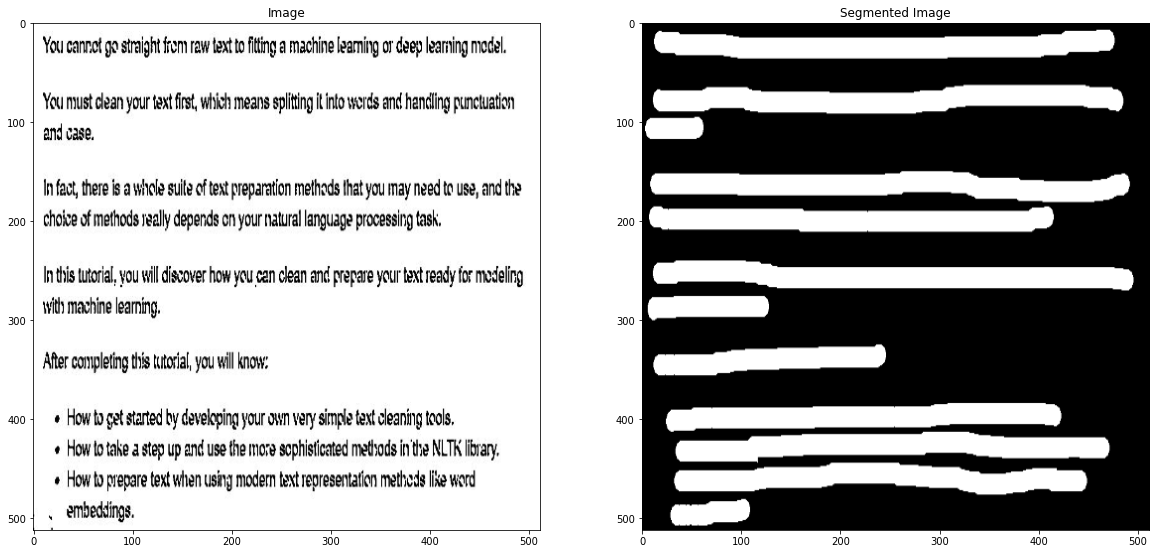

In [ ]:
visualize(df, 60)

## Neural Network

In [ ]:
class Unet(nn.Module):

    def __init__(self):
        super(Unet, self).__init__()
            
        self.conv1 = nn.Conv2d(1, 64, 3, padding='same')
        self.conv2 = nn.Conv2d(64, 64, 3, padding='same')
        self.pool1  = nn.MaxPool2d((2,2))
            
        self.conv3 = nn.Conv2d(64, 128, 3, padding='same')
        self.conv4 = nn.Conv2d(128, 128, 3, padding='same')
        self.pool2  = nn.MaxPool2d((2,2))
            
        self.conv5 = nn.Conv2d(128, 256, 3, padding='same')
        self.conv6 = nn.Conv2d(256, 256, 3, padding='same')
        self.pool3  = nn.MaxPool2d((2,2))
            
        self.conv7 = nn.Conv2d(256, 512, 3, padding='same')
        self.conv8 = nn.Conv2d(512, 512, 3, padding='same')
        self.dropout1 = nn.Dropout(0.5)
        self.pool4 = nn.MaxPool2d((2,2))
            
        self.conv9 = nn.Conv2d(512, 1024, 3, padding='same')
        self.conv10 = nn.Conv2d(1024, 1024, 3, padding='same')
        self.dropout2 = nn.Dropout(0.5)
                   
        self.conv11 = nn.Conv2d(1024, 512, 2, padding='same')
        self.conv12 = nn.Conv2d(1024, 512, 3, padding='same')
        self.conv13 = nn.Conv2d(512, 512, 3, padding='same')
        
        self.conv14 = nn.Conv2d(512, 256, 2, padding='same')
        self.conv15 = nn.Conv2d(512, 256, 3, padding='same')
        self.conv16 = nn.Conv2d(256, 256, 3, padding='same')

        self.conv17 = nn.Conv2d(256, 128, 2, padding='same')
        self.conv18 = nn.Conv2d(256, 128, 3, padding='same')
        self.conv19 = nn.Conv2d(128, 128, 3, padding='same')

        self.conv20 = nn.Conv2d(128, 64, 2, padding='same')
        self.conv21 = nn.Conv2d(128, 64, 3, padding='same')
        self.conv22 = nn.Conv2d(64, 64, 3, padding='same')

        self.conv23 = nn.Conv2d(64, 2, 3, padding='same')
        
        self.conv24 = nn.Conv2d(2, 1, 1, padding='same')
        
        self.merge = lambda x,y : torch.cat((x, y), 1)
        self.upsample = nn.Upsample(scale_factor=2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid() 
            
            
    def foward(self, x):
        
        inputs = x
        
        conv1 = self.relu(self.conv1(inputs))
        conv2 = self.relu(self.conv2(conv1))
        pool1 = self.pool1(conv2)
        
        conv3 = self.relu(self.conv3(pool1))
        conv4 = self.relu(self.conv4(conv3))
        pool2 = self.pool2(conv4)
        
        conv5 = self.relu(self.conv5(pool2))
        conv6 = self.relu(self.conv6(conv5))
        pool3 = self.pool3(conv6)
        
        conv7 = self.relu(self.conv7(pool3))
        conv8 = self.relu(self.conv8(conv7))
        drop1 = self.dropout1(conv8)
        pool4 = self.pool4(drop1)

        conv9 = self.relu(self.conv9(pool4))
        conv10 = self.relu(self.conv10(conv9))
        drop2 = self.dropout2(conv10)
        
        conv11 = self.relu(self.conv11(self.upsample(drop2)))
        merge1 = self.merge(drop1, conv11)
        conv12 = self.relu(self.conv12(merge1))
        conv13 = self.relu(self.conv13(conv12))
        
        conv14 = self.relu(self.conv14(self.upsample(conv13)))
        merge2 = self.merge(conv6, conv14)
        conv15  = self.relu(self.conv15(merge2))
        conv16  = self.relu(self.conv16(conv15))
        
        conv17 = self.relu(self.conv17(self.upsample(conv16)))
        merge3 = self.merge(conv4, conv17)
        conv18 = self.relu(self.conv18(merge3))
        conv19 = self.relu(self.conv19(conv18))
        
        conv20 = self.relu(self.conv20(self.upsample(conv19)))
        merge4 = self.merge(conv2, conv20)
        conv21 = self.relu(self.conv21(merge4))
        conv22 = self.relu(self.conv22(conv21))
        
        conv23 = self.relu(self.conv23(conv22))
        
        output = self.sigmoid(self.conv24(conv23))
                
        return output


    def weight_init(self):
        if isinstance(self, nn.Conv2d) or isinstance(self, nn.Linear):
            nn.init.xavier_uniform_(self.weight, gain=nn.init.calculate_gain('nn.ReLU'))
            nn.init.zeros_(self.bias)

model = Unet()
#model.apply(weight_init)

In [ ]:
epochs = 100
batch_size = 4
data_loader = DataLoader(df, batch_size, shuffle=True)
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [17]:
model.to(device)
losses = []
for epoch in range(1,epochs+1):
  print('EPOCH {}:'.format(epoch))
  running_loss = []
  for i, data in enumerate(data_loader):
      optimizer.zero_grad()
      
      x, y = data

      x=x.to(device)
      y=y.to(device)

      y_pred = model.foward(x)

      loss = criterion(y_pred, y)
      
      running_loss.append(loss.item())

      loss.backward()
      optimizer.step()

  losses.append(np.mean(running_loss))
  print(' LOSS:', np.mean(running_loss))

EPOCH 1:


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:444: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:744.)
  self.padding, self.dilation, self.groups)


 LOSS: 0.5572879008452097
EPOCH 2:
 LOSS: 0.45561493674914044
EPOCH 3:
 LOSS: 0.4449233861764272
EPOCH 4:
 LOSS: 0.4341689944267273
EPOCH 5:
 LOSS: 0.42964687903722126
EPOCH 6:
 LOSS: 0.4270607821146647
EPOCH 7:
 LOSS: 0.42305396556854247
EPOCH 8:
 LOSS: 0.42007338484128315
EPOCH 9:
 LOSS: 0.41662578145662943
EPOCH 10:
 LOSS: 0.4155951468149821
EPOCH 11:
 LOSS: 0.411021253267924
EPOCH 12:
 LOSS: 0.40887564222017925
EPOCH 13:
 LOSS: 0.4045579206943512
EPOCH 14:
 LOSS: 0.40332340558369956
EPOCH 15:
 LOSS: 0.4006518518924713
EPOCH 16:
 LOSS: 0.40108528892199197
EPOCH 17:
 LOSS: 0.394609618584315
EPOCH 18:
 LOSS: 0.392897131840388
EPOCH 19:
 LOSS: 0.3938759692509969
EPOCH 20:
 LOSS: 0.3903540360927582
EPOCH 21:
 LOSS: 0.3923470477263133
EPOCH 22:
 LOSS: 0.38737138628959655
EPOCH 23:
 LOSS: 0.38676059325536094
EPOCH 24:
 LOSS: 0.38180917739868164
EPOCH 25:
 LOSS: 0.38147234757741294
EPOCH 26:
 LOSS: 0.37765576283137003
EPOCH 27:
 LOSS: 0.3767566978931427
EPOCH 28:
 LOSS: 0.37389206608136494

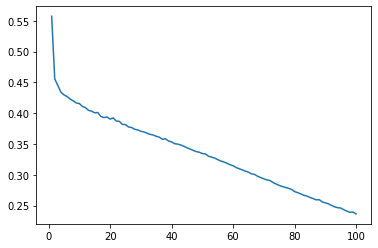

In [18]:
plt.plot(range(1,len(losses)+1),losses)

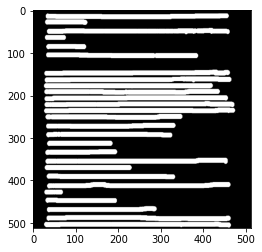

In [28]:
plt.imshow(y[3][0].detach().cpu(), cmap='gray')

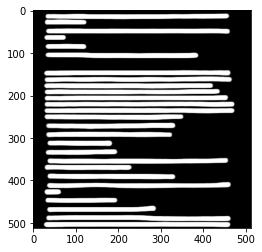

In [26]:
plt.imshow(y_pred[3][0].detach().cpu(), cmap='gray')

In [34]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# # Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([64, 1, 3, 3])
conv1.bias 	 torch.Size([64])
conv2.weight 	 torch.Size([64, 64, 3, 3])
conv2.bias 	 torch.Size([64])
conv3.weight 	 torch.Size([128, 64, 3, 3])
conv3.bias 	 torch.Size([128])
conv4.weight 	 torch.Size([128, 128, 3, 3])
conv4.bias 	 torch.Size([128])
conv5.weight 	 torch.Size([256, 128, 3, 3])
conv5.bias 	 torch.Size([256])
conv6.weight 	 torch.Size([256, 256, 3, 3])
conv6.bias 	 torch.Size([256])
conv7.weight 	 torch.Size([512, 256, 3, 3])
conv7.bias 	 torch.Size([512])
conv8.weight 	 torch.Size([512, 512, 3, 3])
conv8.bias 	 torch.Size([512])
conv9.weight 	 torch.Size([1024, 512, 3, 3])
conv9.bias 	 torch.Size([1024])
conv10.weight 	 torch.Size([1024, 1024, 3, 3])
conv10.bias 	 torch.Size([1024])
conv11.weight 	 torch.Size([512, 1024, 2, 2])
conv11.bias 	 torch.Size([512])
conv12.weight 	 torch.Size([512, 1024, 3, 3])
conv12.bias 	 torch.Size([512])
conv13.weight 	 torch.Size([512, 512, 3, 3])
conv13.bias 	 torch.Size([512]

In [37]:
torch.save(model.state_dict(), Path("/content/drive/MyDrive/datasets/line_seg/model/state_dict.pt"))